3D Scene Reconstruction for a sport facility. 

# Import Libraries

In [1]:
# pip install --trusted-host www.open3d.org -f http://www.open3d.org/docs/latest/getting_started.html open3d


In [2]:
# pip install opencv-contrib-python

In [3]:
import open3d as o3d
import numpy as np
import os
import sys
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.cluster import DBSCAN

# Load_Images

In [4]:
# Load the PNG images using PIL
color_image_pil = Image.open("Sport.png")
depth_image_pil = Image.open("depth_image_sport.png")

## Create the RGBDImage

In [5]:
# Resize depth image to match color image size
depth_image_pil = depth_image_pil.resize(color_image_pil.size, resample=Image.NEAREST)

# Convert Pillow images to Open3D Image objects
color_image = o3d.geometry.Image(np.array(color_image_pil))
depth_image = o3d.geometry.Image(np.array(depth_image_pil))

# Create the RGBDImage
rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(
    color_image, depth_image)


In [6]:
color_image

Image of size 500x333, with 3 channels.
Use numpy.asarray to access buffer data.

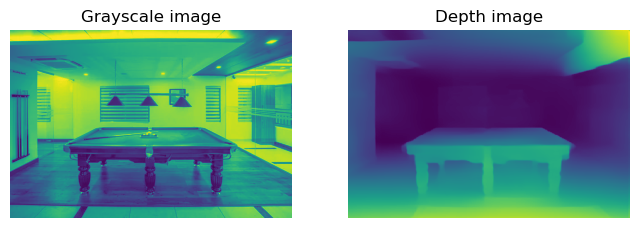

In [7]:
fig, axs=plt.subplots(1,2, figsize=(8,8))
axs[0].imshow(rgbd_image.color)
axs[0].set_title('Grayscale image')
axs[0].axis('off')


axs[1].imshow(rgbd_image.depth)
axs[1].axis('off')
axs[1].set_title('Depth image')
plt.axis('off')

plt.show()

In [8]:
rgbd_image.depth, rgbd_image.color

(Image of size 500x333, with 1 channels.
 Use numpy.asarray to access buffer data.,
 Image of size 500x333, with 1 channels.
 Use numpy.asarray to access buffer data.)

## Camera Intrinsic_Property

The first assumption: I assumed that the picture above was snapped by a Nikon Z6.  
Camera NIKON Z6 details were obtained from https://www.imaging-resource.com/PRODS/nikon-z6/nikon-z6DAT.HTM

This is done to be able to relate the enivoment with the camera that has been used.  
We can get exact measurements of the environment

In [9]:
# Set the image dimensions as in output of cell 6 above
image_width_pixels = 1300
image_height_pixels = 708


# for the horizontal axis # Values in mm
# details from https://www.imaging-resource.com/PRODS/nikon-z6/nikon-z6DAT.HTM
focal_length_mm = 24   
sensor_width_mm = 45.7
sensor_height_mm = 18


# Estimate the camera intrinsic parameters
focal_length_pixelx = (focal_length_mm / sensor_width_mm) * image_width_pixels # Focal length in pixels (estimate)
focal_length_pixely = (focal_length_mm / sensor_height_mm) * image_height_pixels # Focal length in pixels (estimate)

# Calculate the principal point as the center of the image
centre_x = image_width_pixels / 2  # Principal point (estimate)
centre_y = image_height_pixels / 2  # Principal point (estimate)

# Create the pinhole camera intrinsic parameters
camera_intrinsic = o3d.camera.PinholeCameraIntrinsic(
                        width=image_width_pixels, 
                        height=image_height_pixels, 
                        fx=focal_length_pixelx, fy=focal_length_pixely, 
                cx=centre_x, cy=centre_y
                                                )

# Create the Points Cloud

In [10]:
pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image,camera_intrinsic)
pcd 

PointCloud with 165702 points.

In [11]:
# Visualize the point cloud
o3d.visualization.draw_geometries([pcd])

In [12]:
# Define the transformation matrix
transformation_matrix = np.array([[1, 0, 0, 0],
                                  [0, -1, 0, 0],
                                  [0, 0, -1, 0],
                                  [0, 0, 0, 1]])

# Transform the point cloud
transformed_pcd = pcd.transform(transformation_matrix)
transformed_pcd



PointCloud with 165702 points.

In [13]:
# o3d.visualization.draw_geometries([transformed_pcd])

# Voxel_downsampling

In [14]:
print("Downsample the point cloud with a voxel of 0.000005")
downpcd = transformed_pcd.voxel_down_sample(voxel_size=0.000005)
# o3d.visualization.draw_geometries([downpcd])
downpcd

Downsample the point cloud with a voxel of 0.000005


PointCloud with 15917 points.

In [15]:
# print("Downsample the point cloud with a voxel of 0.000001")
# downpcd = transformed_pcd.voxel_down_sample(voxel_size=0.00001)
# # o3d.visualization.draw_geometries([downpcd])
# downpcd

# Region growing segmentation

In [16]:
downpcd.estimate_normals(
    search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))
# o3d.visualization.draw_geometries([downpcd],
#                                   point_show_normal=True)

In [17]:
# Access vertex positions and normals
vertices = np.asarray(downpcd.points)
normals = np.asarray(downpcd.normals)

# DBSCAN

In [18]:
with o3d.utility.VerbosityContextManager(
        o3d.utility.VerbosityLevel.Debug) as cm:
    labels = np.array(
        downpcd.cluster_dbscan(eps=0.00400, min_points=50, print_progress=True))

max_label = labels.max()
print(f"point cloud has {max_label + 1} clusters")
colors = plt.get_cmap("tab20")(labels / (max_label if max_label > 0 else 1))
colors[labels < 0] = 0
downpcd.colors = o3d.utility.Vector3dVector(colors[:, :3])
# o3d.visualization.draw_geometries([downpcd],
#                                   zoom=45,
#                                   front=[-0.4999, -0.1659, -0.8499],
#                                   lookat=[2.1813, 2.0619, 2.0999],
#                                   up=[0.1204, -0.9852, 0.1215])
# o3d.visualization.draw_geometries([downpcd])

[Open3D DEBUG] Precompute neighbors.
[Open3D DEBUG] Done Precompute neighbors.                     ] 2%
[Open3D DEBUG] Compute Clusters
[Open3D DEBUG] Done Compute Clusters: 1
Precompute neighbors.[========================================] 100%
point cloud has 1 clusters========================>] 97%


# NEXT STEP IS TO PERFORM ADVANCE NEURAL NETWORK FOR IMAGE SEGMENTATION

In [19]:
downpcd_tree = o3d.geometry.KDTreeFlann(downpcd)

downpcd.colors[15] = [1,0,0]
[k, idx, _] = downpcd_tree.search_knn_vector_3d(downpcd.points[15], 20)
np.asarray(downpcd.colors)[idx[1:], :]= [0, 0, 1]

In [20]:
o3d.visualization.draw_geometries([downpcd])